# Passage Retrieval - Sparse Embedding

## 1. Introduction to Passage Retrieval

* Passage Retrieval
  * 질문(query)에 맞는 문서(passage)를 찾는 것
  * database에 찾고자 하는 문서 또는 데이터 조각이 있을 때, 질문이 들어오면 그 조각을 찾아서 내보내주는 것
  * database 형태는 다양함

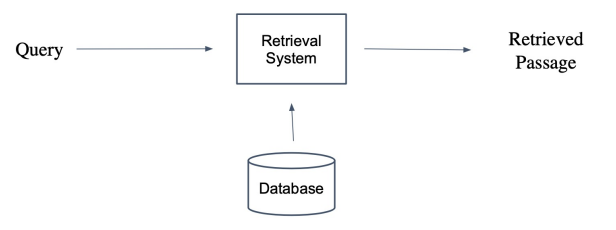

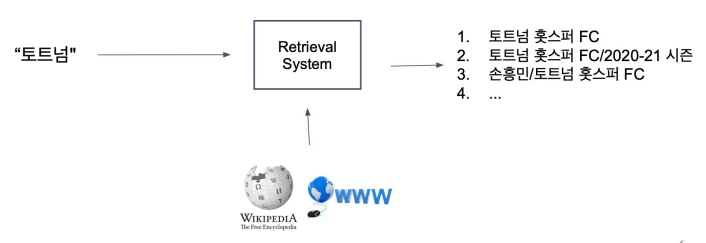

* Passage Retrieval with MRC
  * Retrieval system을 MRC system과 연결하면 ODQA(open-domain question answering)을 할 수 있음
  * Open-domain Question Answering : 대규모의 문서 중에서 질문에 대한 답을 찾기
    * Passage Retrieval과 MRC를 이어서 2-Stage로 만들 수 있음(2-stage pipeline)
      * stage1 : passage retrieval
        * 질문과 관련되거나 질문을 포함하고 있을 것 같은 지문을 찾아서 MRC model에 넘김
      * stage2 : MRC model은 들어온 지문을 보고 질문을 다시 읽어봄으로써 정확한 답변을 냄

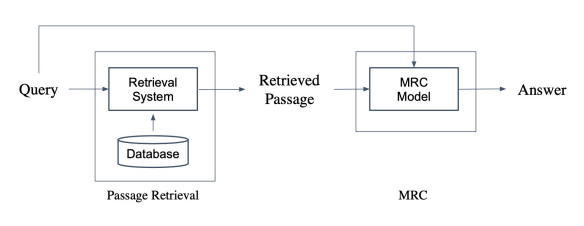

* Overview of Passage Retrieval
  * Query와 Passage를 임베딩한 뒤 유사도로 랭킹을 매기고, 유사도가 가장 높은 Passage를 선택함

  * passage retrieval implementation 접근 방법
    * 일반적으로 embedding space에서 검색함
    * 질문이 들어왔을 때 질문을 어떤 vector space로 embedding함
    * 같은 vector space에 passage embedding을 함
      * passage embedding(지문 embedding)은 미리 해두어 효율성을 높임
    * 들어온 질문에 대해 각 passage의 embedding과 서로 similarity score를 계산함
      * nearest neighbor : 일반적으로 많이 사용하는 similarity score를 계산하는 방법. 고차원 space에서 서로의 거리가 얼마나 되는지를 보거나 또는 inner product같은 서로의 dot product를 계산하여 가장 높은 score가 내는 passage를 찾는 방식
    * similarity score를 모든 passage에 관해서 잰 다음 score 들을 ranking을 하여 가장 높은 문서 순서대로 내보내주는 방식

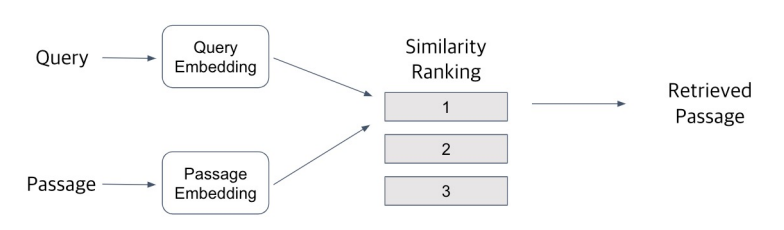

## 2. Passage Embedding and Sparse Embedding

* 최종 목표 : Passage를 vector space에 mapping 하는 것
  * vector space : 여러개의 숫자로 이루어져있는 point들이 모여있는 고차원적인 추상적인 공간

* Passage Embedding Space
  * Passage Embedding의 벡터 공간
  * 벡터화된 Passage를 이용하여 Passage 간 유사도 등을 알고리즘으로 계산할 수 있음
  * vector space상에서 두 문서간의 유사도 또는 문서와 질문간의 유사도를 거리로 계산함(inner product같은 유사도를 통해서도 관련성 계산 가능함)

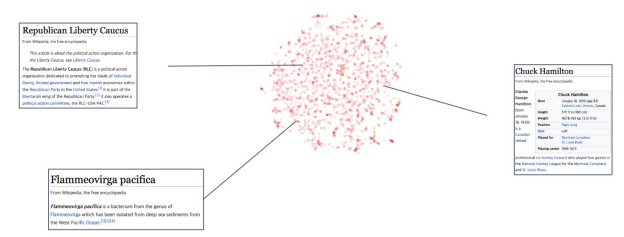

* Sparse Embedding 소개
  * Sparse(<->dense) : 0이 아닌 숫자가 매우 적게 있는 것을 의미함
  * Bag-of-Words(BoW) : 대표적인 Sparse Embedding 방법
    * 문서가 주어졌을 때, 문서를 embedding space로 mapping하기 위해서 각 문서에 존재하는 단어들을 1(존재하는 경우) 또는 0(존재하지 않는 경우)으로 표현하여 아주 긴 vector로 표현하는 것을 의미함
    * 특정 단어의 존재여부로 표현하기 때문에 vector 길이는 고려하고 있는 전체 vocabulary size와 동일함
      * ex. vocabluary size가 30만개일 경우 모든 단어가 30만 vector space로 표현됨
    * 각각의 dimension이 하나의 단어에 해당됨

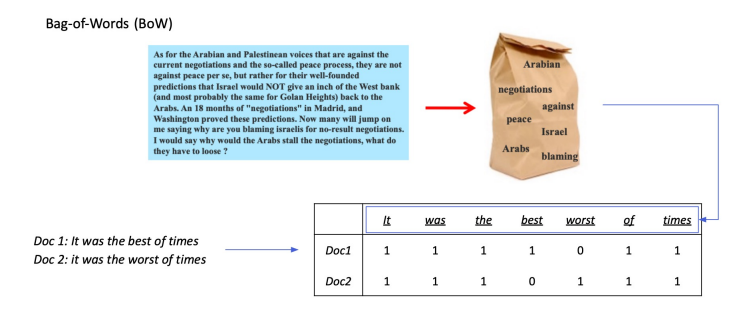

* Sparse Embedding 소개
  1. BoW를 구성하는 방법 -> n-gram
    * unigram (1-gram) : *It was the best of times* => *It, was, the, best, of, timeㄴ*
      * vector 크기가 vocabulary size와 동일함
    * bigram (2-gram) : *It was the best of times* => *It was, was the, the best, best of, of times*
    * n이 증가할수록 vocabulary size가 기하급수적으로 증가함
      * 일반적으로 bigram까지 활용함
      * 경우에 따라 trigram 까지 활용함
  2. Term value를 결정하는 방법
    * Term이 document에 등장하는지 (binary)
      * vanilla한 경우, 이것만 고려(1/0으로 표현)
    * Term이 몇 번 등장하는지 (term frequency), 등. (e.g. TF-IDF)

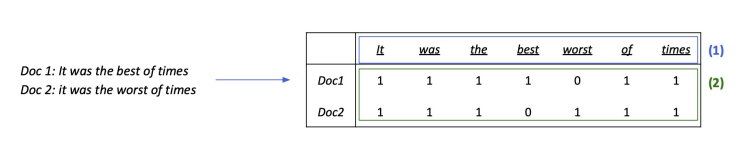

* Sparce Embedding 특징
  1. Dimension of embedding vector = number of terms
    * dimension은 vocab size(총 term이 가능한 개수)에 의해 결정됨
    * 등장하는 단어가 많아질수록 증가
    * N-gram의 n이 커질수록 증가

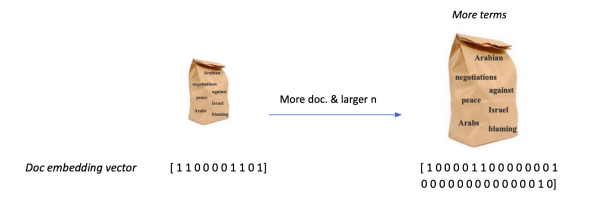

* Sparse Embedding 특징
  2. Term overlap을 정확하게 잡아내야할 때 유용함
    * 검색 단어가 실제 해당 문서에 들어가 있는지 확인
  3. 반면, 의미(semantic)가 비슷하지만 다른 단어인 경우 비교가 불가함

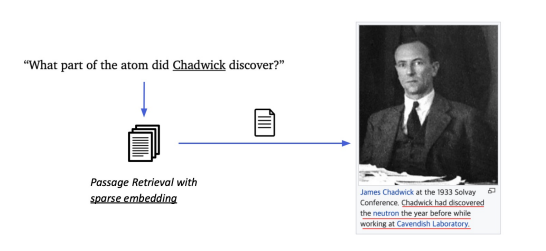

## 3. TF-IDF

* TF-IDF (Term Frequency - Inverse Document Frequency) 소개
  * Term Frequency (TF) : 단어의 등장빈도
  * Inverse Document Frequency (IDF) : 단어가 제공하는 정보의 양(단어가 얼마나 덜 등장하는지)
  * TF와 IDF 두 개의 숫자를 곱하여 최종 수치를 계산함
    * 특정 문서에서 자주 등장한 단어가 전체 문서에서 별로 등장하지 않는 경우, 그 단어는 해당 문서(특정 문서)에서 중요하므로 해당 단어에 높은 점수를 부여함
  <br> ex) *It was the best of times*
  <br> -> *It*, *was*, *the*, *of* : 자주 등장하지만 제공하는 정보량이 적음
  <br> -> *best*, *times* : 좀 더 많은 정보를 제공함(IDF score가 좀 더 높음)


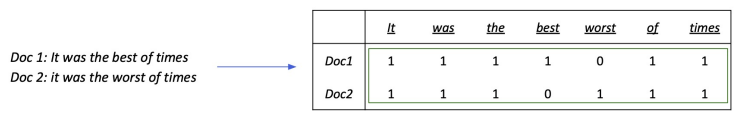

* Term Frequency (TF)
  * 해당 문서 내 단어의 등장 빈도
    
  1. Raw count
    * BoW와 달리 2번 등장하면 2가 됨
  2. Adjusted for doc length: raw count / num words (TF)
    * 일반적으로 normalize함 : 실제 문서 내에서 총 단어의 개수를 확인하여 비중을 비율로 나타내며 총 합은 1 이하
  3. Other variants: binary, log normalization, etc.

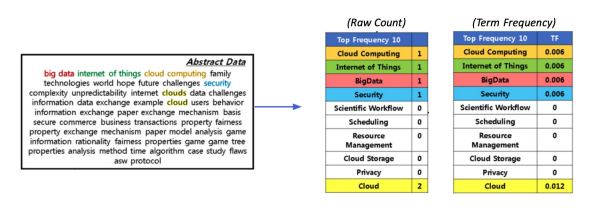

* Inverse Document Frequency (IDF)
  * 단어가 제공하는 정보의 양
$$IDF(t) = \log{N \over {DF(t)}}$$
  * Document Frequency (DF) = Term $t$가 등장한 document의 개수
  * N : 총 document의 개수
  * 모든 문서에 등장하는 단어는 IDF score가 0이 됨
  * 단어가 등장하는 문서의 개수가 적을수록 DF score가 작아져서 IDF score가 커지게 됨

  <br> ex) 문서의 개수가 100이라고 할 때, 'the'에 대한 DF score는 100
  <br> => N과 DF score가 모두 100이기 때문에 IDF score는 0이 됨

  * IDF는 TF와 달리 각 term에 특정되고 문서에는 무관함

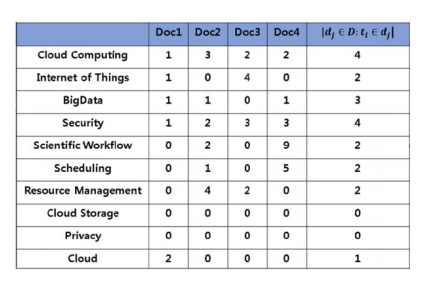

* Combine TF & IDF
  * TF-IDF($t$, $d$) : TF-IDF for term $t$ in document $d$, 
$$TF(t, d) \times IDF(t)$$
    * 'a', 'the' 등 관사 => <U>LOW TF-IDF</U>
    <br> : TF는 높을 수 있지만, IDF가 0에 가까울 것(거의 모든 document에 등장 => $N \approx DF(t)$ => $\log(N/DF) \approx 0$)
    * 자주 등장하지 않는 고유 명사 (ex. 사람 이름, 지명 등) => <U>High TF-IDF</U>
    <br> : IDF가 커지면서 전체적인 TF-IDF 값이 증가함

* TF-IDF 계산하기
  * 실험할 데이터 : 

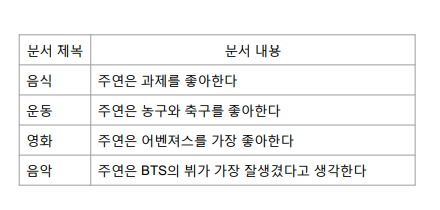

* TF-IDF 계산하기
  * 토크나이저
    * 여기에서는 unigram만 고려하여 실험함

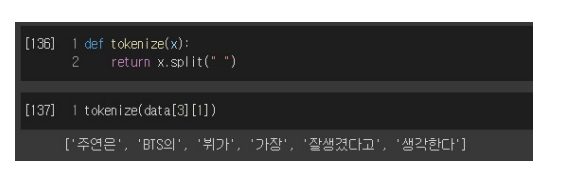

* TF-IDF 계산하기
  * Term Frequency (TF) : 단어의 등장 빈도
  * TF($t$, $d$) : TF for term $t$ and document $d$

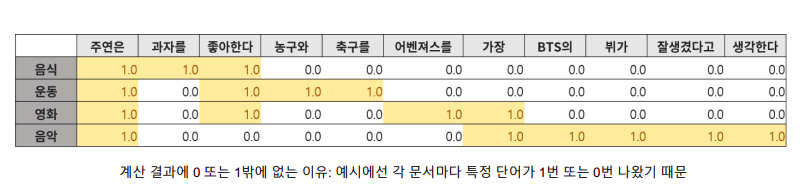

* TF-IDF 계산하기
  * Inverse Document Frequency (IDF) : 단어가 제공하는 정보의 양
$$IDF(t) = \log{N \over {DF(t)}}$$

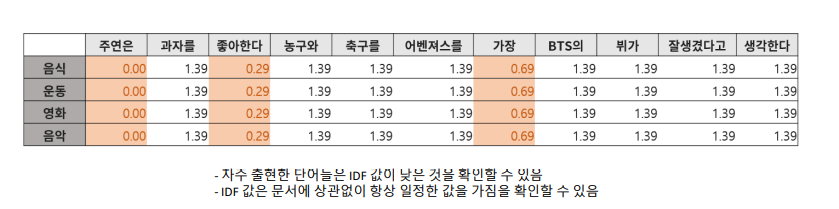

* TF-IDF 계산하기
  * TF-IDF 계산
$$TF(t, d) \times IDF(t)$$
  * 결과를 vector화 하면 각 문서의 TF-IDF vector가 됨

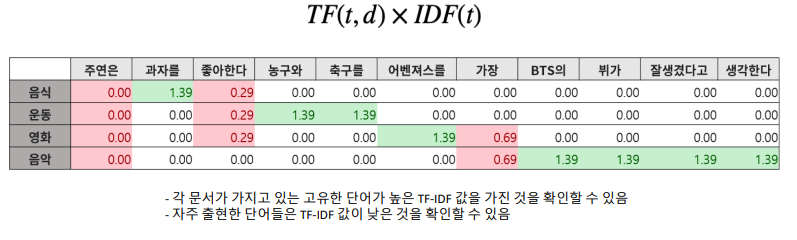

* TF-IDF를 이용해 유사도 구해보기
  * 목표 : 계산한 문서 TF-IDF를 가지고 질의 TF-IDF를 계산한 후 가장 관련있는 문서를 찾기

  * 질문을 같은 방식으로 문서라고 생각하고 TF-IDF score를 구한 후 두 개의 vector의 (문서의 TF-IDF vector와 질문의 TF-IDF vector) 유사도를 구함
    * TF-IDF의 경우 일반적으로 cosine distance를 구함
      * normalize한 후에 inner product를 하게 되면 cosine distance가 됨

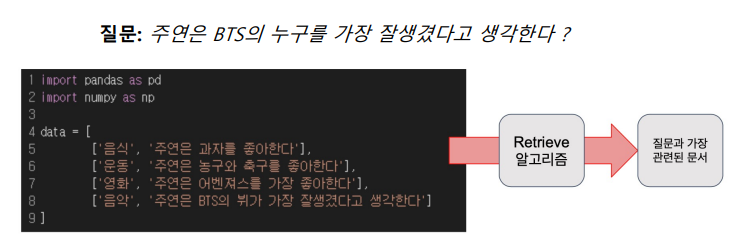

* TF-IDF를 이용해 유사도 구해보기
  * 목표 : 계산한 TF-IDF를 가지고 사용자가 물어본 질의에 대해 가장 관련있는 문서 찾기

  1. 사용자가 입력한 질의를 토큰화
  2. 기존에 단어 사전에 없는 토큰들은 제외
  3. 질의를 하나의 문서로 생각하고, 이에 대한 TF-IDF 계산
  4. 질의 TF-IDF 값과 각 문서별 TF-IDF 값을 곱하여 유사도 점수 계산
$$Score(D, Q) = \sum_{term \in Q}{TFIDF(term, Q) * TFIDF(term, D)}$$
    * inner product 함으로서 score를 계산하는 공식
  5. 가장 높은 점수를 가지는 문서 선택

* TF-IDF를 이용해 유사도 구해보기
  * 가장 가까운 단어 '음악'을 찾음

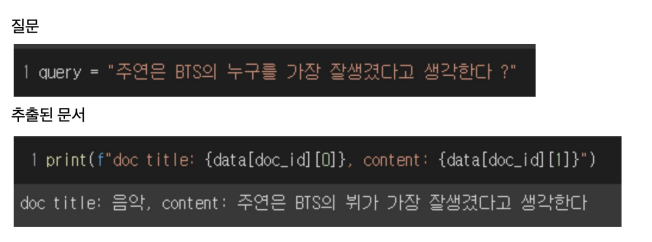

* BM25 란?
  * TF-IDF 의 개념을 바탕으로, 문서의 길이까지 고려하여 점수를 매김
    * TF 값에 한계를 지정해두어 일정한 범위를 유지하도록 함
    * 평균적인 문서의 길이보다 더 작은 문서에서 단어가 매칭된 경우 그 문서에 대해 가중치를 부여함
    * 실제 검색엔진, 추천 시스템 등에서 아직까지도 많이 사용되는 알고리즘

$$ Score(D, Q) = \sum_{term \in Q}{IDF(term) \cdot {{TFIDF(term, D) \cdot (k_{1} + 1)} \over {TFIDF(term, D) + k_{1} \cdot (1 - b + b \cdot {{\left\vert D \right\vert} \over {avgdl}})}}}$$